In [1]:
import pandas as pd

# Replace with your file path if needed
file_path = "full_data.csv"

# Read the CSV file
full = pd.read_csv(file_path)

# Display the first few rows of the dataset
full.head(1)


,ANON_ID,Birthdate,Gen,Eth,Fluency,SpEd,Grade,AttRate,DaysEnr,DaysAbs,Susp,CurrWeightedTotGPA,SED,Year,School
0,338,2003-07-21,F,Latino,RFEP,Not Special Ed,9,0.9889,180.0,2.0,NaN,3.65,Unknown,17-18,Castlemont


In [2]:
full.describe()
full.shape

(21994, 15)

In [3]:
full.columns

Index(['ANON_ID', 'Birthdate', 'Gen', 'Eth', 'Fluency', 'SpEd', 'Grade',
       'AttRate', 'DaysEnr', 'DaysAbs', 'Susp', 'CurrWeightedTotGPA', 'SED',
       'Year', 'School'],
      dtype='object')

In [4]:
# Check for null values in each column
null_counts = full.isnull().sum()

# Display the number of nulls per column
print(null_counts)


ANON_ID                   0
Birthdate                 0
Gen                       0
Eth                       0
Fluency                   0
SpEd                      0
Grade                     0
AttRate                  29
DaysEnr                  29
DaysAbs                  29
Susp                  20556
CurrWeightedTotGPA     6441
SED                       0
Year                      0
School                    0
dtype: int64


In [5]:
# Display data types of each column
print(full.dtypes)


ANON_ID                 int64
Birthdate              object
Gen                    object
Eth                    object
Fluency                object
SpEd                   object
Grade                   int64
AttRate               float64
DaysEnr               float64
DaysAbs               float64
Susp                  float64
CurrWeightedTotGPA    float64
SED                    object
Year                   object
School                 object
dtype: object


In [6]:
# Identify categorical columns (object or category dtype)
categorical_columns = full.select_dtypes(include=['object', 'category']).columns

# Print unique values for each categorical column
for col in categorical_columns:
    print(f"Column: {col}")
    print(full[col].unique())
    print("\n")


Column: Birthdate
['2003-07-21' '2003-03-31' '2003-09-06' ... '2012-08-23' '2011-08-16'
 '2012-01-10']


Column: Gen
['F' 'M' 'N' 'm']


Column: Eth
['Latino' 'Multiple Ethnicity' 'Not Reported' 'African American' 'White'
 'Filipino' 'Asian' 'Native American' 'Pacific Islander']


Column: Fluency
['RFEP' 'EL' 'EO' 'TBD' 'IFEP' 'Unknown']


Column: SpEd
['Not Special Ed' 'Special Ed']


Column: SED
['Unknown' 'SED' 'Not SED']


Column: Year
['17-18' '18-19' '19-20' '20-21' '21-22' '22-23' '23-24']


Column: School
['Castlemont' 'EOP' 'Elmhurst' 'Mack' 'MLK' 'Prescott' 'WOMS']




In [7]:
!pip install imbalanced-learn

In [16]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
)
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# Preprocessing (Your provided preprocessing code with modifications)
full_data = full.copy()

# Separate data for training (2017-2023) and test (2023-2024)
train_data = full_data[full_data['Year'].isin(['17-18', '18-19', '19-20', '20-21', '21-22', '22-23'])]
test_data = full_data[full_data['Year'] == '23-24']

# Drop columns that are unnecessary for both datasets
columns_to_drop = ['ANON_ID', 'Birthdate', 'Susp', 'School', 'Year']
train_data = train_data.drop(columns=columns_to_drop, errors='ignore')
test_data = test_data.drop(columns=columns_to_drop, errors='ignore')

# Shuffle training data
train_data = train_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Handle inconsistent values in 'Gen' for both datasets
train_data['Gen'] = train_data['Gen'].str.upper()
test_data['Gen'] = test_data['Gen'].str.upper()

# Fill missing values for previous years' data using SimpleImputer
numeric_columns = ['AttRate', 'DaysEnr', 'DaysAbs', 'CurrWeightedTotGPA']

imputer = SimpleImputer(strategy='mean')
train_data[numeric_columns] = imputer.fit_transform(train_data[numeric_columns])
test_data[numeric_columns] = imputer.transform(test_data[numeric_columns])

# Create the target variable 'ChronicAbsentee' for both datasets
train_data['ChronicAbsentee'] = (train_data['DaysAbs'] / train_data['DaysEnr'] > 0.10).astype(int)
test_data['ChronicAbsentee'] = (test_data['DaysAbs'] / test_data['DaysEnr'] > 0.10).astype(int)

# Drop columns used to create the target variable to prevent leakage
train_data = train_data.drop(columns=['DaysAbs', 'DaysEnr', 'AttRate'], errors='ignore')
test_data = test_data.drop(columns=['DaysAbs', 'DaysEnr', 'AttRate'], errors='ignore')

# One-hot encode categorical variables for both datasets
categorical_columns = ['Gen', 'Eth', 'Fluency', 'SpEd', 'SED']
train_data = pd.get_dummies(train_data, columns=categorical_columns, drop_first=True)
test_data = pd.get_dummies(test_data, columns=categorical_columns, drop_first=True)

# Ensure the test dataset has the same columns as the training dataset
test_data = test_data.reindex(columns=train_data.columns, fill_value=0)


In [17]:
# Separate features and target for Below Grade 6
train_below_6 = train_data[train_data['Grade'] < 6].drop(columns=['CurrWeightedTotGPA'])
test_below_6 = test_data[test_data['Grade'] < 6].drop(columns=['CurrWeightedTotGPA'])

X_train_below_6 = train_below_6.drop(columns=['ChronicAbsentee'])
y_train_below_6 = train_below_6['ChronicAbsentee']

X_test_below_6 = test_below_6.drop(columns=['ChronicAbsentee'])
y_test_below_6 = test_below_6['ChronicAbsentee']

# Separate features and target for Grade 6 and Above
train_above_6 = train_data[train_data['Grade'] >= 6]
test_above_6 = test_data[test_data['Grade'] >= 6]

X_train_above_6 = train_above_6.drop(columns=['ChronicAbsentee'])
y_train_above_6 = train_above_6['ChronicAbsentee']

X_test_above_6 = test_above_6.drop(columns=['ChronicAbsentee'])
y_test_above_6 = test_above_6['ChronicAbsentee']

# Scale features
scaler = StandardScaler()
X_train_below_6_scaled = scaler.fit_transform(X_train_below_6)
X_test_below_6_scaled = scaler.transform(X_test_below_6)

X_train_above_6_scaled = scaler.fit_transform(X_train_above_6)
X_test_above_6_scaled = scaler.transform(X_test_above_6)

# Use class_weight='balanced' in Random Forest to handle class imbalance
rf_classifier = RandomForestClassifier(random_state=42, class_weight='balanced')

In [18]:
# Hyperparameter Tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}
grid_search_below_6 = GridSearchCV(rf_classifier, param_grid, cv=3, scoring='accuracy')
grid_search_above_6 = GridSearchCV(rf_classifier, param_grid, cv=3, scoring='accuracy')

# Train the models
grid_search_below_6.fit(X_train_below_6_scaled, y_train_below_6)
grid_search_above_6.fit(X_train_above_6_scaled, y_train_above_6)

# Best models
best_model_below_6 = grid_search_below_6.best_estimator_
best_model_above_6 = grid_search_above_6.best_estimator_

In [20]:
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, recall_score, precision_score, classification_report

# Evaluate for Below Grade 6
y_pred_below_6 = best_model_below_6.predict(X_test_below_6)
y_proba_below_6 = best_model_below_6.predict_proba(X_test_below_6)[:, 1]

print("Below Grade 6 Metrics")
print("Confusion Matrix:\n", confusion_matrix(y_test_below_6, y_pred_below_6))
print("AUC Score:", roc_auc_score(y_test_below_6, y_proba_below_6))
print("F1 Score:", f1_score(y_test_below_6, y_pred_below_6))
print("Recall:", recall_score(y_test_below_6, y_pred_below_6))
print("Precision:", precision_score(y_test_below_6, y_pred_below_6))
print("\nClassification Report:\n", classification_report(y_test_below_6, y_pred_below_6))

# Evaluate for Grade 6 and Above
y_pred_above_6 = best_model_above_6.predict(X_test_above_6)
y_proba_above_6 = best_model_above_6.predict_proba(X_test_above_6)[:, 1]

print("Grade 6 and Above Metrics")
print("Confusion Matrix:\n", confusion_matrix(y_test_above_6, y_pred_above_6))
print("AUC Score:", roc_auc_score(y_test_above_6, y_proba_above_6))
print("F1 Score:", f1_score(y_test_above_6, y_pred_above_6))
print("Recall:", recall_score(y_test_above_6, y_pred_above_6))
print("Precision:", precision_score(y_test_above_6, y_pred_above_6))
print("\nClassification Report:\n", classification_report(y_test_above_6, y_pred_above_6))


Below Grade 6 Metrics
Confusion Matrix:
 [[  0 502]
 [  0 427]]
AUC Score: 0.5231416255353295
F1 Score: 0.6297935103244838
Recall: 1.0
Precision: 0.4596340150699677

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       502
           1       0.46      1.00      0.63       427

    accuracy                           0.46       929
   macro avg       0.23      0.50      0.31       929
weighted avg       0.21      0.46      0.29       929

Grade 6 and Above Metrics
Confusion Matrix:
 [[884 143]
 [763 405]]
AUC Score: 0.6669879019887691
F1 Score: 0.47202797202797203
Recall: 0.3467465753424658
Precision: 0.7390510948905109

Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.86      0.66      1027
           1       0.74      0.35      0.47      1168

    accuracy                           0.59      2195
   macro avg       0.64      0.60      0.57      2195
w

/Users/wuhaowen/Desktop/venv/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/wuhaowen/Desktop/venv/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/wuhaowen/Desktop/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/wuhaowen/Desktop/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

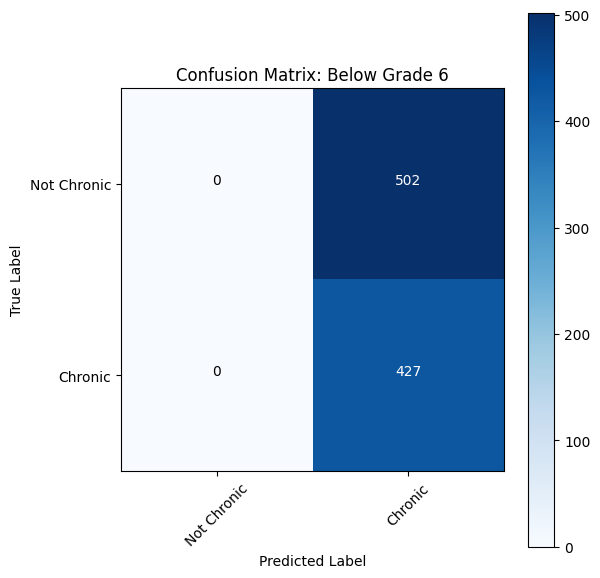

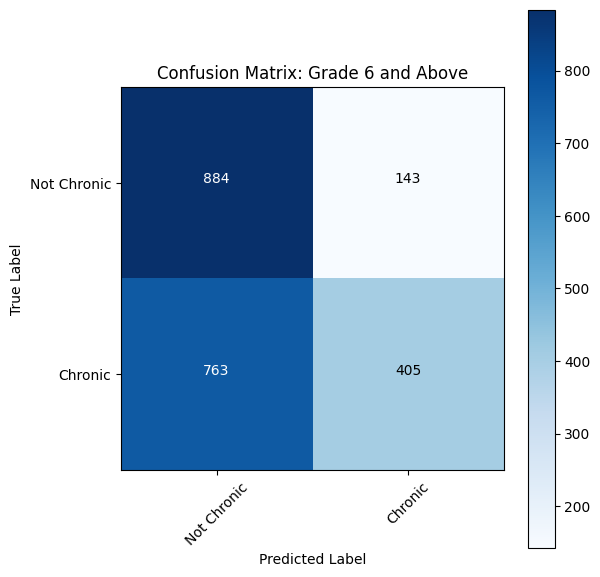

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    Plots a confusion matrix.
    """
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Annotate confusion matrix
    fmt = 'd'
    thresh = cm.max() / 2
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Example usage for Below Grade 6
cm_below_6 = confusion_matrix(y_test_below_6, y_pred_below_6)
plot_confusion_matrix(cm_below_6, classes=["Not Chronic", "Chronic"], title="Confusion Matrix: Below Grade 6")

# Example usage for Grade 6 and Above
cm_above_6 = confusion_matrix(y_test_above_6, y_pred_above_6)
plot_confusion_matrix(cm_above_6, classes=["Not Chronic", "Chronic"], title="Confusion Matrix: Grade 6 and Above")


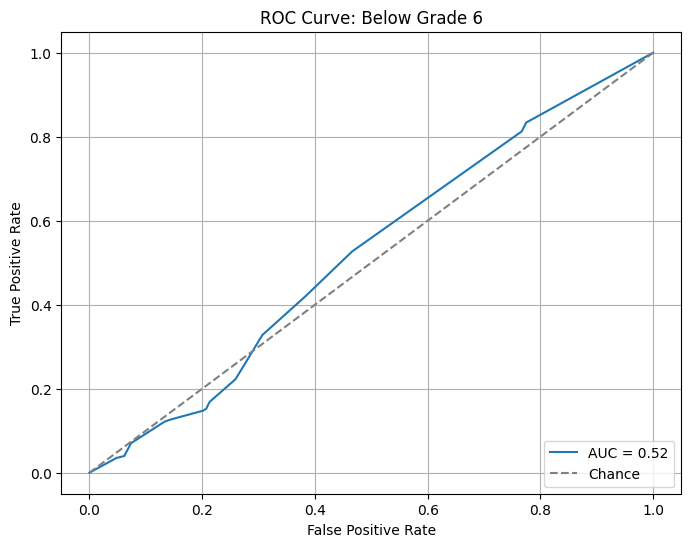

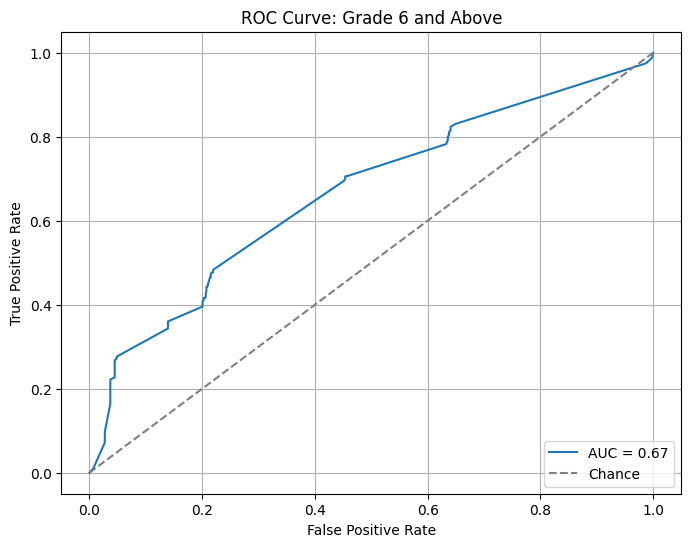

In [22]:
from sklearn.metrics import roc_curve

def plot_roc_curve(y_test, y_proba, title='ROC Curve'):
    """
    Plots the ROC curve.
    """
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Chance")
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# Example usage for Below Grade 6
plot_roc_curve(y_test_below_6, y_proba_below_6, title="ROC Curve: Below Grade 6")

# Example usage for Grade 6 and Above
plot_roc_curve(y_test_above_6, y_proba_above_6, title="ROC Curve: Grade 6 and Above")


In [35]:
#improved below 6 model

Class Distribution for Below Grade 6 (Training Data):
ChronicAbsentee
0    3081
1    2423
Name: count, dtype: int64
Class Distribution for Below Grade 6 (After Undersampling):
ChronicAbsentee
0    2423
1    2423
Name: count, dtype: int64
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best Parameters for Below Grade 6 Model:
{'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Below Grade 6 Metrics After Improvements
Confusion Matrix:
 [[200 302]
 [115 312]]
AUC Score: 0.5864481185328941
F1 Score: 0.5994236311239193
Recall: 0.7306791569086651
Precision: 0.50814332247557

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.40      0.49       502
           1       0.51      0.73      0.60       427

    accuracy                           0.55       929
   macro avg       0.57      0.56      0.54       929
weighted avg       0.58      0.55 

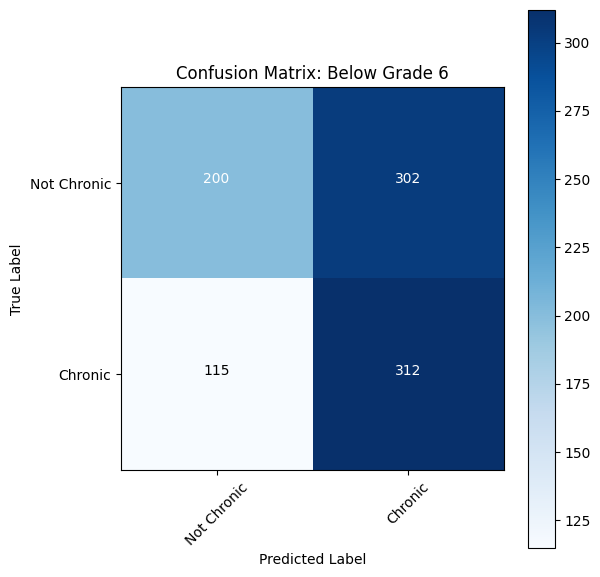

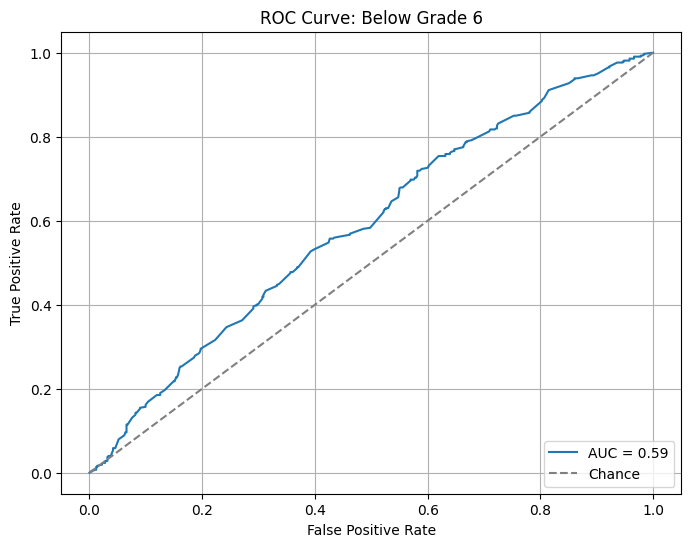

In [24]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    roc_auc_score,
    f1_score,
    recall_score,
    precision_score,
    classification_report
)
from imblearn.under_sampling import RandomUnderSampler

# Step 1: Check Class Distribution
print("Class Distribution for Below Grade 6 (Training Data):")
print(y_train_below_6.value_counts())

# Step 2: Handle Imbalance More Effectively
undersampler = RandomUnderSampler(random_state=42)
X_train_below_6_resampled, y_train_below_6_resampled = undersampler.fit_resample(X_train_below_6, y_train_below_6)

print("Class Distribution for Below Grade 6 (After Undersampling):")
print(pd.Series(y_train_below_6_resampled).value_counts())

# Step 3: Tune the Hyperparameters Further
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Define Random Forest with Balanced Class Weight
rf_classifier = RandomForestClassifier(random_state=42, class_weight='balanced')

# Step 4: Use Stratified Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search_below_6 = GridSearchCV(
    estimator=rf_classifier,
    param_grid=param_grid,
    cv=cv,
    scoring='f1',  # Optimize F1 score
    n_jobs=-1,
    verbose=1
)

# Train the Grid Search Model
grid_search_below_6.fit(X_train_below_6_resampled, y_train_below_6_resampled)

# Retrieve the Best Model
best_model_below_6 = grid_search_below_6.best_estimator_
print("Best Parameters for Below Grade 6 Model:")
print(grid_search_below_6.best_params_)

# Predict on the Test Set
y_pred_below_6 = best_model_below_6.predict(X_test_below_6)
y_proba_below_6 = best_model_below_6.predict_proba(X_test_below_6)[:, 1]

# Step 5: Evaluate the Improved Model
print("Below Grade 6 Metrics After Improvements")
print("Confusion Matrix:\n", confusion_matrix(y_test_below_6, y_pred_below_6))
print("AUC Score:", roc_auc_score(y_test_below_6, y_proba_below_6))
print("F1 Score:", f1_score(y_test_below_6, y_pred_below_6))
print("Recall:", recall_score(y_test_below_6, y_pred_below_6))
print("Precision:", precision_score(y_test_below_6, y_pred_below_6))
print("\nClassification Report:\n", classification_report(y_test_below_6, y_pred_below_6))
    

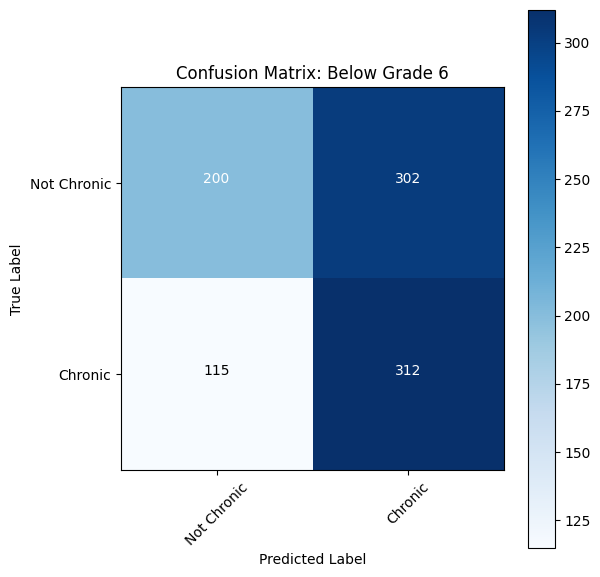

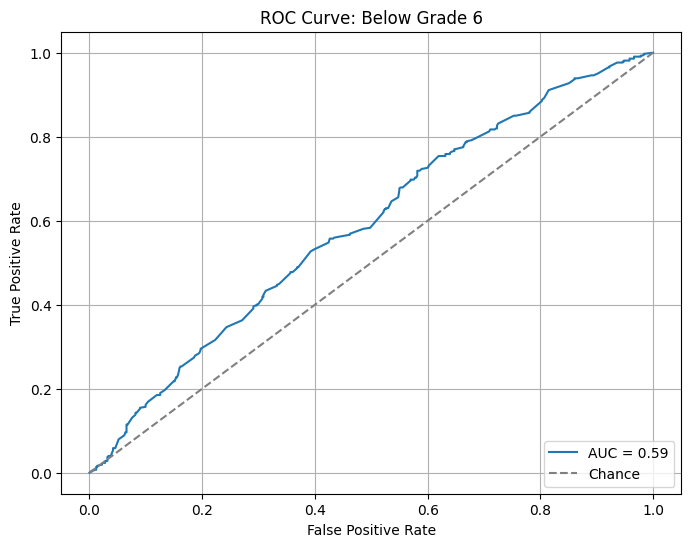

In [25]:
# Plot Confusion Matrix
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

cm_below_6 = confusion_matrix(y_test_below_6, y_pred_below_6)
plot_confusion_matrix(cm_below_6, classes=["Not Chronic", "Chronic"], title="Confusion Matrix: Below Grade 6")

# Plot ROC Curve
from sklearn.metrics import roc_curve

def plot_roc_curve(y_test, y_proba, title='ROC Curve'):
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Chance")
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

plot_roc_curve(y_test_below_6, y_proba_below_6, title="ROC Curve: Below Grade 6")


In [36]:
#below are the current model i'm using to write the report

In [26]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Create a working copy of the dataset
full_data = full.copy()

# Separate data for training (2017-2023) and test (2023-2024)
train_data = full_data[full_data['Year'].isin(['17-18', '18-19', '19-20', '20-21', '21-22', '22-23'])]
test_data = full_data[full_data['Year'] == '23-24']

# Drop unnecessary columns
columns_to_drop = ['ANON_ID', 'Birthdate', 'Susp', 'School', 'Year']
train_data = train_data.drop(columns=columns_to_drop, errors='ignore')
test_data = test_data.drop(columns=columns_to_drop, errors='ignore')

# Shuffle training data
train_data = train_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Handle inconsistent values in 'Gen'
train_data['Gen'] = train_data['Gen'].str.upper()
test_data['Gen'] = test_data['Gen'].str.upper()

# Fill missing values
numeric_columns = ['AttRate', 'DaysEnr', 'DaysAbs', 'CurrWeightedTotGPA']
imputer = SimpleImputer(strategy='mean')
train_data[numeric_columns] = imputer.fit_transform(train_data[numeric_columns])
test_data[numeric_columns] = imputer.transform(test_data[numeric_columns])

# Create the target variable 'ChronicAbsentee'
train_data['ChronicAbsentee'] = (train_data['DaysAbs'] / train_data['DaysEnr'] > 0.10).astype(int)
test_data['ChronicAbsentee'] = (test_data['DaysAbs'] / test_data['DaysEnr'] > 0.10).astype(int)

# Drop columns used to create the target variable
train_data = train_data.drop(columns=['DaysAbs', 'DaysEnr', 'AttRate'], errors='ignore')
test_data = test_data.drop(columns=['DaysAbs', 'DaysEnr', 'AttRate'], errors='ignore')

# One-hot encode categorical variables
categorical_columns = ['Gen', 'Eth', 'Fluency', 'SpEd', 'SED']
train_data = pd.get_dummies(train_data, columns=categorical_columns, drop_first=True)
test_data = pd.get_dummies(test_data, columns=categorical_columns, drop_first=True)

# Ensure the test dataset has the same columns as the training dataset
test_data = test_data.reindex(columns=train_data.columns, fill_value=0)

# Separate features and target for Below Grade 6
train_below_6 = train_data[train_data['Grade'] < 6].drop(columns=['CurrWeightedTotGPA'])
test_below_6 = test_data[test_data['Grade'] < 6].drop(columns=['CurrWeightedTotGPA'])

X_train_below_6 = train_below_6.drop(columns=['ChronicAbsentee'])
y_train_below_6 = train_below_6['ChronicAbsentee']

X_test_below_6 = test_below_6.drop(columns=['ChronicAbsentee'])
y_test_below_6 = test_below_6['ChronicAbsentee']

# Separate features and target for Grade 6 and Above
train_above_6 = train_data[train_data['Grade'] >= 6]
test_above_6 = test_data[test_data['Grade'] >= 6]

X_train_above_6 = train_above_6.drop(columns=['ChronicAbsentee'])
y_train_above_6 = train_above_6['ChronicAbsentee']

X_test_above_6 = test_above_6.drop(columns=['ChronicAbsentee'])
y_test_above_6 = test_above_6['ChronicAbsentee']

# Scale features
scaler = StandardScaler()
X_train_below_6_scaled = scaler.fit_transform(X_train_below_6)
X_test_below_6_scaled = scaler.transform(X_test_below_6)

X_train_above_6_scaled = scaler.fit_transform(X_train_above_6)
X_test_above_6_scaled = scaler.transform(X_test_above_6)


In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    roc_auc_score,
    f1_score,
    recall_score,
    precision_score,
    classification_report
)
from imblearn.under_sampling import RandomUnderSampler

# Check Class Distribution
print("Class Distribution for Below Grade 6 (Training Data):")
print(y_train_below_6.value_counts())

# Handle Imbalance with Random Undersampling
undersampler = RandomUnderSampler(random_state=42)
X_train_below_6_resampled, y_train_below_6_resampled = undersampler.fit_resample(X_train_below_6, y_train_below_6)

print("Class Distribution After Undersampling:")
print(pd.Series(y_train_below_6_resampled).value_counts())

# Hyperparameter Tuning for Below Grade 6
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

rf_classifier = RandomForestClassifier(random_state=42, class_weight='balanced')
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search_below_6 = GridSearchCV(
    rf_classifier, param_grid, cv=cv, scoring='f1', n_jobs=-1, verbose=1
)
grid_search_below_6.fit(X_train_below_6_resampled, y_train_below_6_resampled)

# Best Model for Below Grade 6
best_model_below_6 = grid_search_below_6.best_estimator_
print("Best Parameters for Below Grade 6 Model:")
print(grid_search_below_6.best_params_)

# Evaluate Below Grade 6 Model
y_pred_below_6 = best_model_below_6.predict(X_test_below_6)
y_proba_below_6 = best_model_below_6.predict_proba(X_test_below_6)[:, 1]

print("Below Grade 6 Metrics")
print("Confusion Matrix:\n", confusion_matrix(y_test_below_6, y_pred_below_6))
print("AUC Score:", roc_auc_score(y_test_below_6, y_proba_below_6))
print("F1 Score:", f1_score(y_test_below_6, y_pred_below_6))
print("Recall:", recall_score(y_test_below_6, y_pred_below_6))
print("Precision:", precision_score(y_test_below_6, y_pred_below_6))
print("\nClassification Report:\n", classification_report(y_test_below_6, y_pred_below_6))


Class Distribution for Below Grade 6 (Training Data):
ChronicAbsentee
0    3081
1    2423
Name: count, dtype: int64
Class Distribution After Undersampling:
ChronicAbsentee
0    2423
1    2423
Name: count, dtype: int64
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


/Users/wuhaowen/Desktop/venv/lib/python3.9/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters for Below Grade 6 Model:
{'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Below Grade 6 Metrics
Confusion Matrix:
 [[200 302]
 [115 312]]
AUC Score: 0.5864481185328941
F1 Score: 0.5994236311239193
Recall: 0.7306791569086651
Precision: 0.50814332247557

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.40      0.49       502
           1       0.51      0.73      0.60       427

    accuracy                           0.55       929
   macro avg       0.57      0.56      0.54       929
weighted avg       0.58      0.55      0.54       929



In [31]:
# Hyperparameter Tuning for Grade 6 and Above
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

grid_search_above_6 = GridSearchCV(
    rf_classifier, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=1
)
grid_search_above_6.fit(X_train_above_6_scaled, y_train_above_6)

# Best Model for Grade 6 and Above
best_model_above_6 = grid_search_above_6.best_estimator_
print("Best Parameters for Grade 6 and Above Model:")
print(grid_search_above_6.best_params_)

# Evaluate Grade 6 and Above Model
y_pred_above_6 = best_model_above_6.predict(X_test_above_6_scaled)
y_proba_above_6 = best_model_above_6.predict_proba(X_test_above_6_scaled)[:, 1]

print("Grade 6 and Above Metrics")
print("Confusion Matrix:\n", confusion_matrix(y_test_above_6, y_pred_above_6))
print("AUC Score:", roc_auc_score(y_test_above_6, y_proba_above_6))
print("F1 Score:", f1_score(y_test_above_6, y_pred_above_6))
print("Recall:", recall_score(y_test_above_6, y_pred_above_6))
print("Precision:", precision_score(y_test_above_6, y_pred_above_6))
print("\nClassification Report:\n", classification_report(y_test_above_6, y_pred_above_6))


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Parameters for Grade 6 and Above Model:
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Grade 6 and Above Metrics
Confusion Matrix:
 [[691 336]
 [337 831]]
AUC Score: 0.7492876412212722
F1 Score: 0.7117773019271949
Recall: 0.711472602739726
Precision: 0.712082262210797

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.67      0.67      1027
           1       0.71      0.71      0.71      1168

    accuracy                           0.69      2195
   macro avg       0.69      0.69      0.69      2195
weighted avg       0.69      0.69      0.69      2195



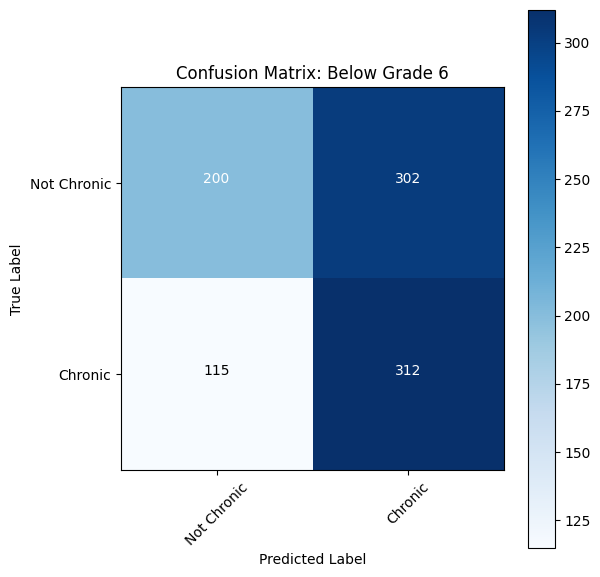

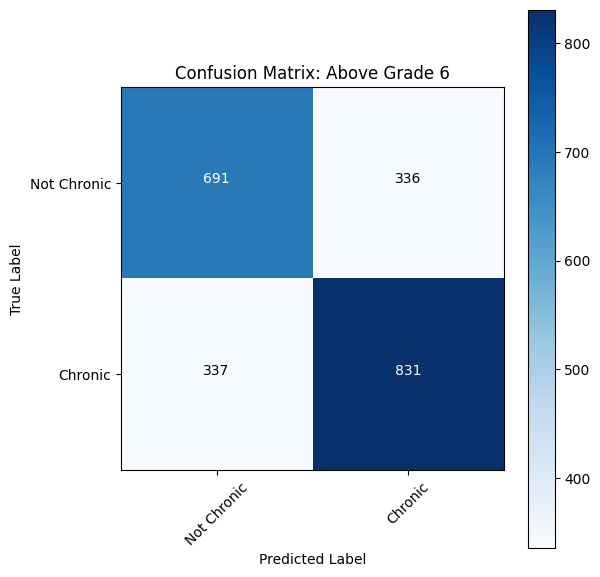

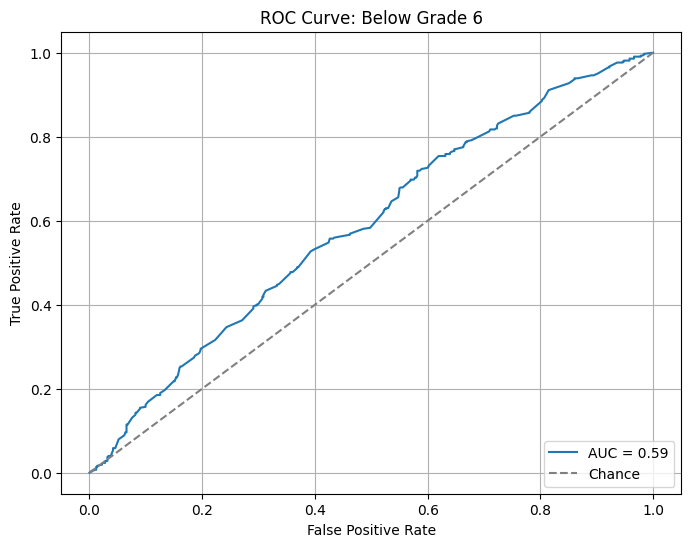

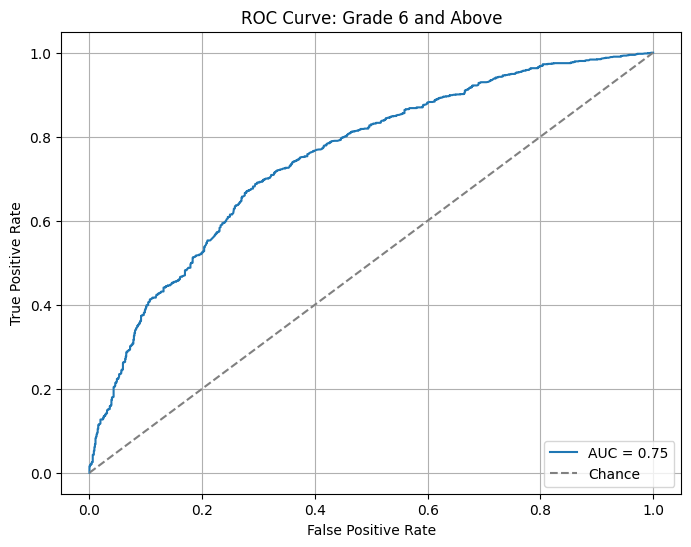

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Confusion Matrix Plot
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Plot Confusion Matrix for Below Grade 6
cm_below_6 = confusion_matrix(y_test_below_6, y_pred_below_6)
plot_confusion_matrix(cm_below_6, classes=["Not Chronic", "Chronic"], title="Confusion Matrix: Below Grade 6")

cm_above_6 = confusion_matrix(y_test_above_6, y_pred_above_6)
plot_confusion_matrix(cm_above_6, classes=["Not Chronic", "Chronic"], title="Confusion Matrix: Above Grade 6")

# Plot ROC Curve
def plot_roc_curve(y_test, y_proba, title='ROC Curve'):
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Chance")
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# Plot ROC Curve for Below Grade 6
plot_roc_curve(y_test_below_6, y_proba_below_6, title="ROC Curve: Below Grade 6")

# Plot ROC Curve for Grade 6 and Above
plot_roc_curve(y_test_above_6, y_proba_above_6, title="ROC Curve: Grade 6 and Above")


In [33]:
# Add school names to the test datasets
test_below_6['School'] = full_data[full_data['Year'] == '23-24']['School']
test_above_6['School'] = full_data[full_data['Year'] == '23-24']['School']

# Add predictions to the Below Grade 6 dataset
test_below_6['Predicted_ChronicAbsentee'] = best_model_below_6.predict(X_test_below_6)
test_below_6['Prediction_Probability'] = best_model_below_6.predict_proba(X_test_below_6)[:, 1]

# Add predictions to the Grade 6 and Above dataset
test_above_6['Predicted_ChronicAbsentee'] = best_model_above_6.predict(X_test_above_6_scaled)
test_above_6['Prediction_Probability'] = best_model_above_6.predict_proba(X_test_above_6_scaled)[:, 1]

# Combine predictions into one DataFrame
predictions = pd.concat([
    test_below_6[['School', 'Predicted_ChronicAbsentee', 'Prediction_Probability']],
    test_above_6[['School', 'Predicted_ChronicAbsentee', 'Prediction_Probability']]
])

# Save to CSV
predictions.to_csv('predictions_2023_2024.csv', index=False)
print("Predictions for 2023-2024 saved to 'predictions_2023_2024.csv'")


Predictions for 2023-2024 saved to 'predictions_2023_2024.csv'


/var/folders/ml/58hsqq6s44l0l8l89l9_99km0000gn/T/ipykernel_14574/150557710.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_above_6['School'] = full_data[full_data['Year'] == '23-24']['School']
/var/folders/ml/58hsqq6s44l0l8l89l9_99km0000gn/T/ipykernel_14574/150557710.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_above_6['Predicted_ChronicAbsentee'] = best_model_above_6.predict(X_test_above_6_scaled)
/var/folders/ml/58hsqq6s44l0l8l89l9_99km0000gn/T/ipykernel_14574/150557710.py:11: Settin